# Домашнє завдання: Прогнозування кредитного ризику

## Мета завдання
Застосувати знання з лекції для побудови моделі логістичної регресії, що прогнозує ймовірність дефолту за кредитом, іншими словами, що людина не поверне кредит. Ви пройдете весь цикл: від дослідницького аналізу до оцінки якості класифікаційної моделі.

## Опис датасету
**Credit Risk Dataset** містить інформацію про 32,000+ позичальників з такими параметрами:
- **person_age**: Вік позичальника
- **person_income**: Річний дохід
- **person_home_ownership**: Тип володіння житлом
- **person_emp_length**: Стаж роботи (в роках)
- **loan_intent**: Мета кредиту
- **loan_grade**: Кредитний рейтинг (A - кращий, F - гірший)
- **loan_amnt**: Сума кредиту
- **loan_int_rate**: Процентна ставка
- **loan_status**: Статус кредиту (0 = сплачено, 1 = дефолт) - **цільова змінна**
- **loan_percent_income**: Відношення кредиту до доходу
- **cb_person_default_on_file**: Історія дефолтів (Y/N)
- **cb_person_cred_hist_length**: Довжина кредитної історії

---

## Завдання 1: Завантаження та перший огляд даних (1 бал)

**Що потрібно зробити:**
1. Завантажте дані з файлу `credit_risk_dataset.csv`
2. Виведіть розмір датасету
3. Покажіть перші 5 рядків
4. Виведіть загальну інформацію про дані (кількість записів, типи колонок)
5. Перевірте розподіл цільової змінної (відсотк даних для кожного класу)

Дайте висновок, це задача збалансованої чи незбалансованої класифікації.


In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
df = pd.read_csv("../data/credit_risk_dataset.csv")

In [4]:
df.shape

(32581, 12)

In [5]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [7]:
loan_status_percent = df['loan_status'].value_counts(normalize=True) * 100

loan_status_percent

loan_status
0    78.183604
1    21.816396
Name: proportion, dtype: float64

Маємо задачу незбалансованої класифікації


---

## Завдання 2: Дослідницький аналіз даних (EDA) (4 бали)

**Що потрібно зробити:**
1. Обчисліть відсоток пропущених значень в колонках. За наявності пропущених значень - заповніть їх медіаною для числових колонок і найбільш частим значеннмя для категоріальних.
2. Проаналізуйте розподіл числових змінних.
3. Знайдіть та обробіть викиди в колонці person_income з допомогою [Interquartile range](https://uk.wikipedia.org/wiki/%D0%9C%D1%96%D0%B6%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B8%D0%BB%D1%8C%D0%BD%D0%B8%D0%B9_%D1%80%D0%BE%D0%B7%D0%BC%D0%B0%D1%85).
4. Проаналізуйте категоріальні змінні відносно цільової та частоту зустрічання різних значень в них.
5. Візуалізуйте взаємозв'язок ознак з цільовою змінною.


In [8]:
mis_data = df.isnull().sum()
mis_data_pers = (mis_data/len(df))*100
mis_data_pers

person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
person_emp_length             2.747000
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
loan_int_rate                 9.563856
loan_status                   0.000000
loan_percent_income           0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
dtype: float64

In [9]:
df['person_emp_length'] = pd.to_numeric(df['person_emp_length'], errors='coerce')
df['person_emp_length'] = df['person_emp_length'].fillna(df['person_emp_length'].median())

In [10]:
df['loan_int_rate'] = pd.to_numeric(df['loan_int_rate'], errors='coerce')
df['loan_int_rate'] = df['loan_int_rate'].fillna(df['loan_int_rate'].median())

In [11]:
df.select_dtypes("number").describe().round(3)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000,32581.000,32581.000,32581.000,32581.000,32581.000,32581.000,32581.000
mean,27.735,66074.848,4.768,9589.371,11.010,0.218,0.170,5.804
std,6.348,61983.119,4.087,6322.087,3.082,0.413,0.107,4.055
min,20.000,4000.000,0.000,500.000,5.420,0.000,0.000,2.000
25%,23.000,38500.000,2.000,5000.000,8.490,0.000,0.090,3.000
50%,26.000,55000.000,4.000,8000.000,10.990,0.000,0.150,4.000
75%,30.000,79200.000,7.000,12200.000,13.110,0.000,0.230,8.000
max,144.000,6000000.000,123.000,35000.000,23.220,1.000,0.830,30.000


З аналізу розподілу видно, що дані мають сильну праву асиметрію, а також естремальні максимальні значення, що виглядають нереалістично. Тож треба перевірити та проаналізувати викиди.

In [12]:
Q1 = df['person_income'].quantile(0.25)
Q3 = df['person_income'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df['person_income'] = df['person_income'].clip(
    lower=lower_bound,
    upper=upper_bound
)

In [13]:
cat_cols = df.select_dtypes(include='object').columns

print('Частота зустрічання різних значень в категоріальних колонках')
print("-"*50)
for col in cat_cols:
    print(df[col].value_counts(normalize=True).round(3))
    print("-"*20)

Частота зустрічання різних значень в категоріальних колонках
--------------------------------------------------
person_home_ownership
RENT        0.505
MORTGAGE    0.413
OWN         0.079
OTHER       0.003
Name: proportion, dtype: float64
--------------------
loan_intent
EDUCATION            0.198
MEDICAL              0.186
VENTURE              0.176
PERSONAL             0.169
DEBTCONSOLIDATION    0.160
HOMEIMPROVEMENT      0.111
Name: proportion, dtype: float64
--------------------
loan_grade
A    0.331
B    0.321
C    0.198
D    0.111
E    0.030
F    0.007
G    0.002
Name: proportion, dtype: float64
--------------------
cb_person_default_on_file
N    0.824
Y    0.176
Name: proportion, dtype: float64
--------------------


Частіше кредит беруть ті, в кого немає власножо житла, або ті в кого іпотека. Причини отримання кредиту розподіляються досить рівномірно у відсодковому співвідношенні, але частіше беруть на навчання та медичні послуги. Більшість кредитів дають особам з високим кредитним рейтингом і у 82%-х випадків кредит повертають.

In [14]:
for col in cat_cols:
    display(
        df.groupby(col)['loan_status']
          .agg(['count','mean'])
          .sort_values('mean', ascending=False)
    )

,count,mean
person_home_ownership,,
RENT,16446,0.315700
OTHER,107,0.308411
MORTGAGE,13444,0.125707
OWN,2584,0.074690


,count,mean
loan_intent,,
DEBTCONSOLIDATION,5212,0.285879
MEDICAL,6071,0.267007
HOMEIMPROVEMENT,3605,0.261026
PERSONAL,5521,0.198877
EDUCATION,6453,0.172168
VENTURE,5719,0.148103


,count,mean
loan_grade,,
G,64,0.984375
F,241,0.705394
E,964,0.644191
D,3626,0.590458
C,6458,0.207340
B,10451,0.162760
A,10777,0.099564


,count,mean
cb_person_default_on_file,,
Y,5745,0.378068
N,26836,0.183932


Найбільш ризиковою категорією клієнтів є ті, що орендують житло. Вони не повертають кредит в 31,6% випадків. Щодо цілей кредитування, то найбільший ризик у категоріях консолідації кредиту, медицина, а також ремонт житла.Якщо аналізувати клієнтів за кредитним рейтингом, то тут все очевидно, чим гірший рейтинг, тим більший відсоток неповернень.

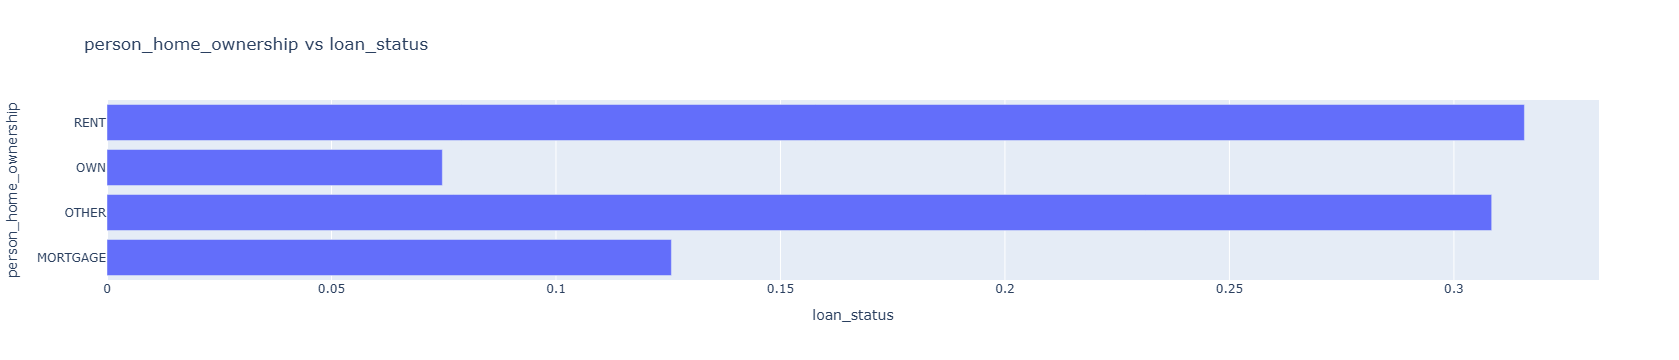

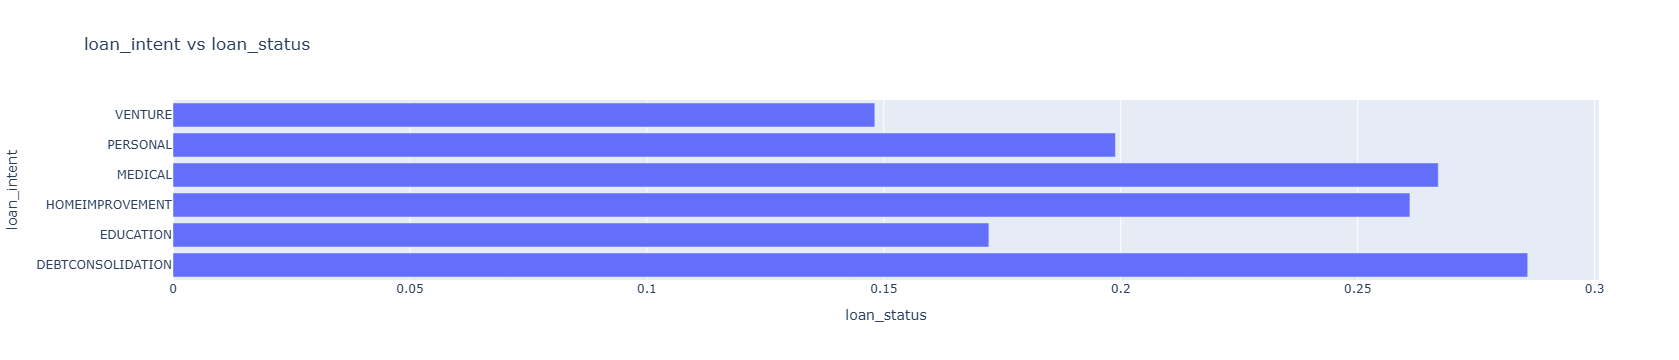

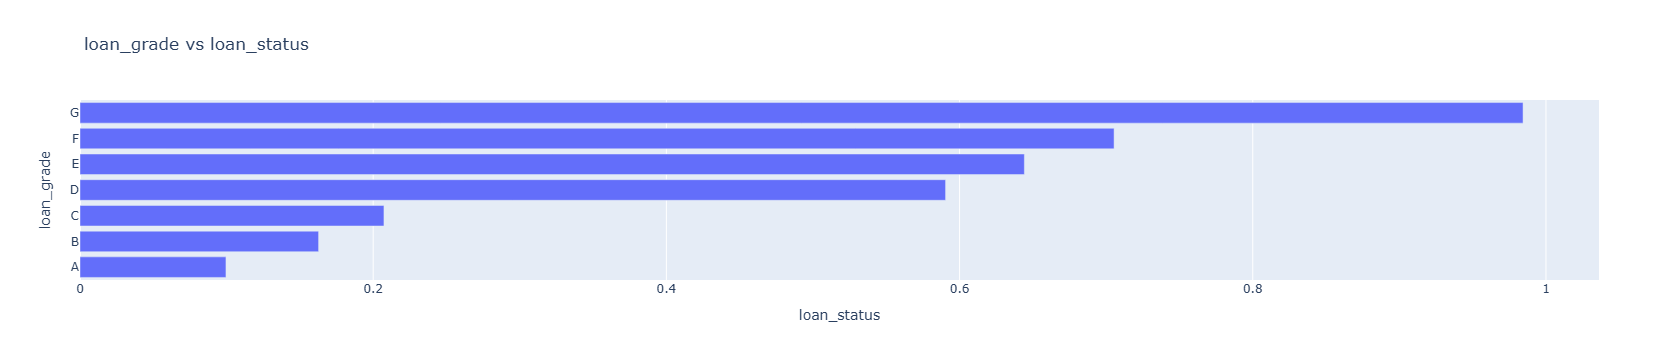

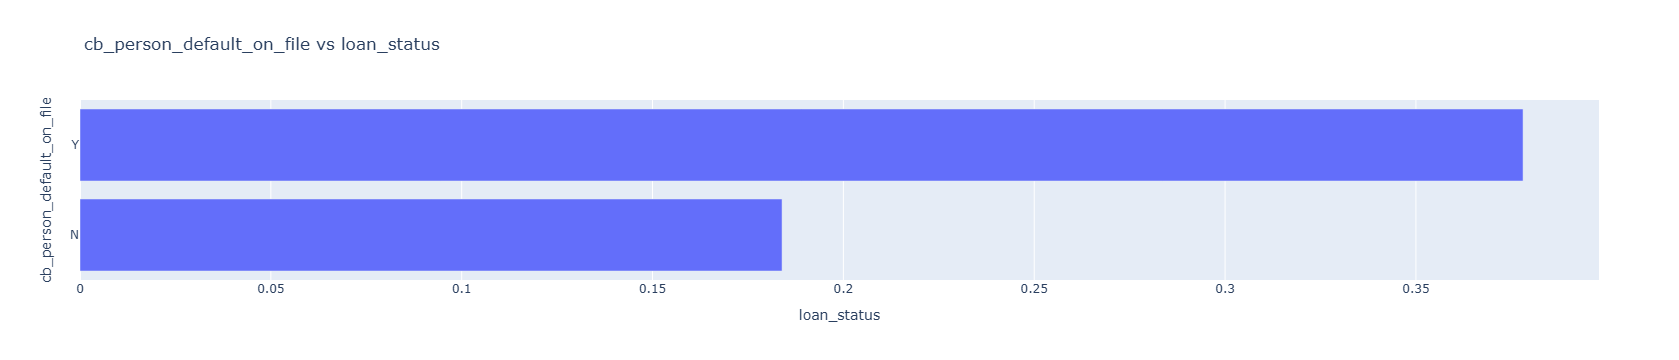

In [15]:
for col in cat_cols:
    fig = px.bar(
        df.groupby(col)['loan_status'].mean().reset_index(),
        x = 'loan_status',
        y = col,
        title=f'{col} vs loan_status')
    fig.show()  

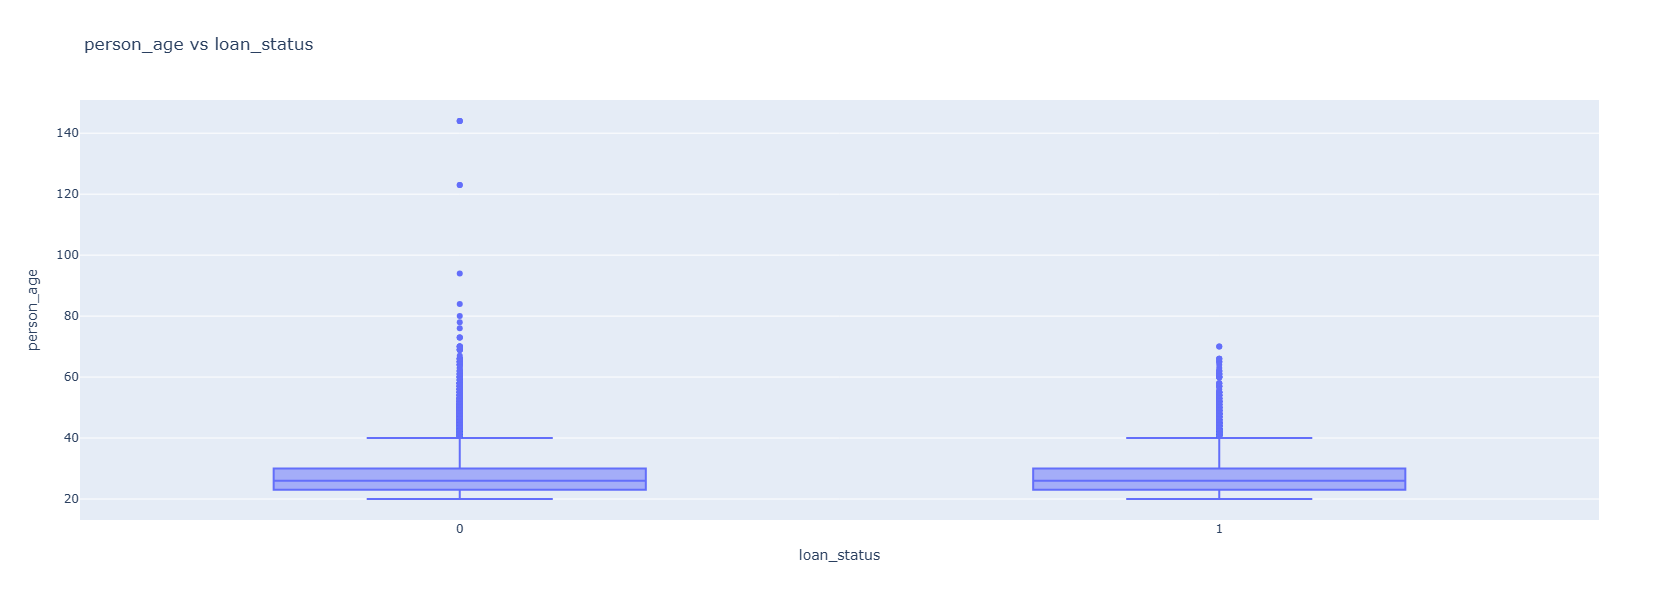

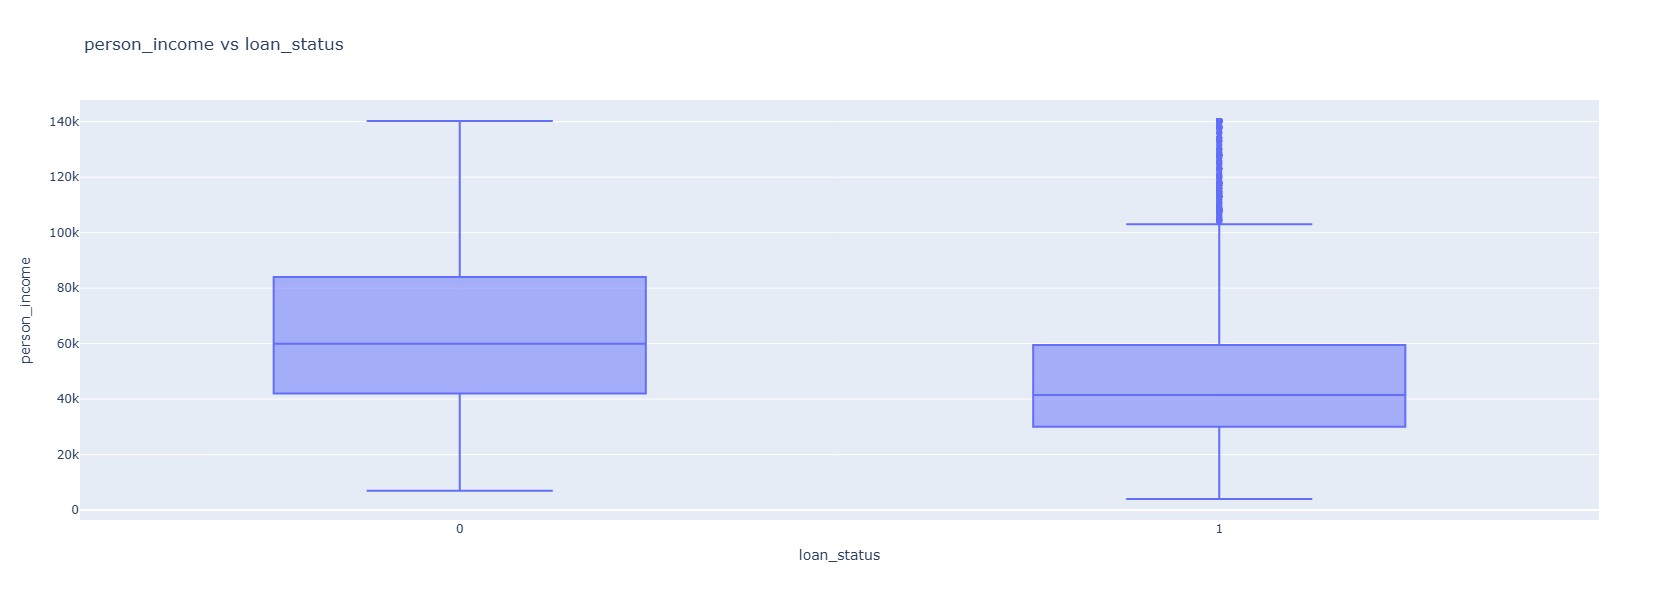

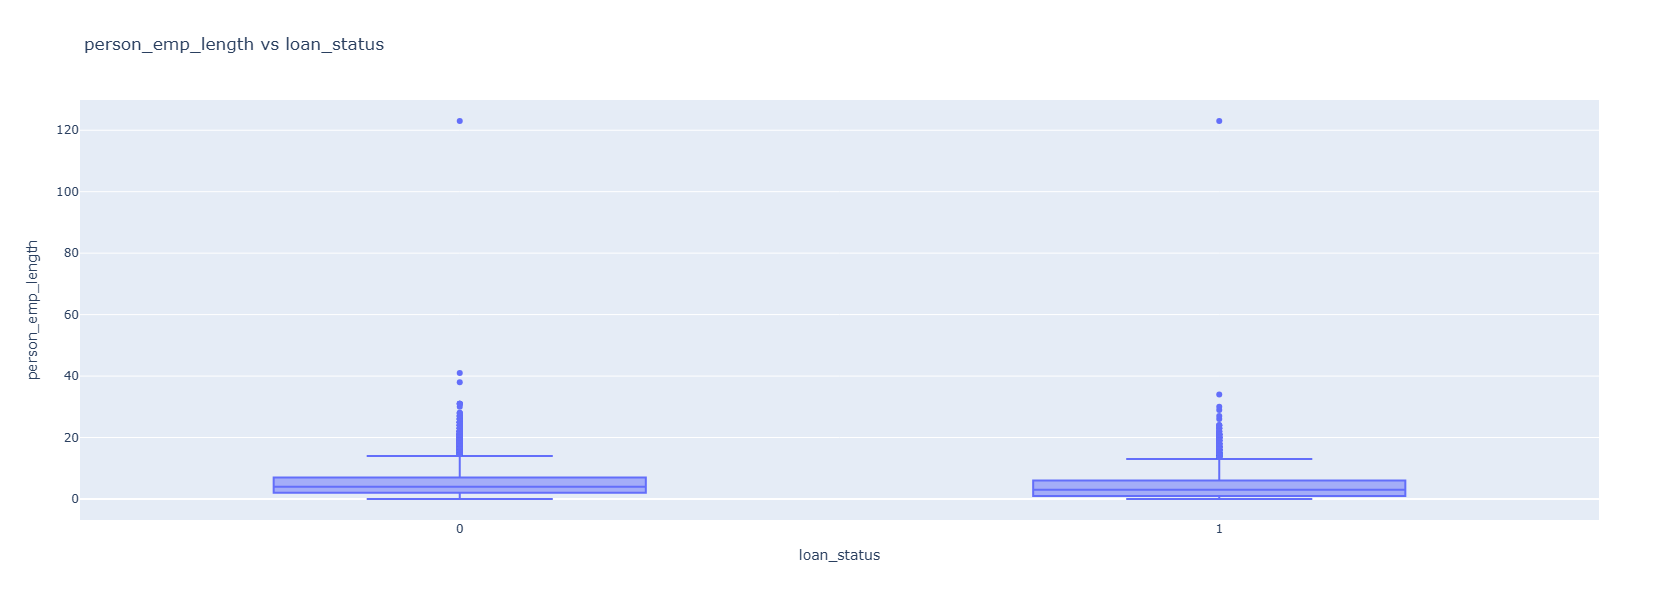

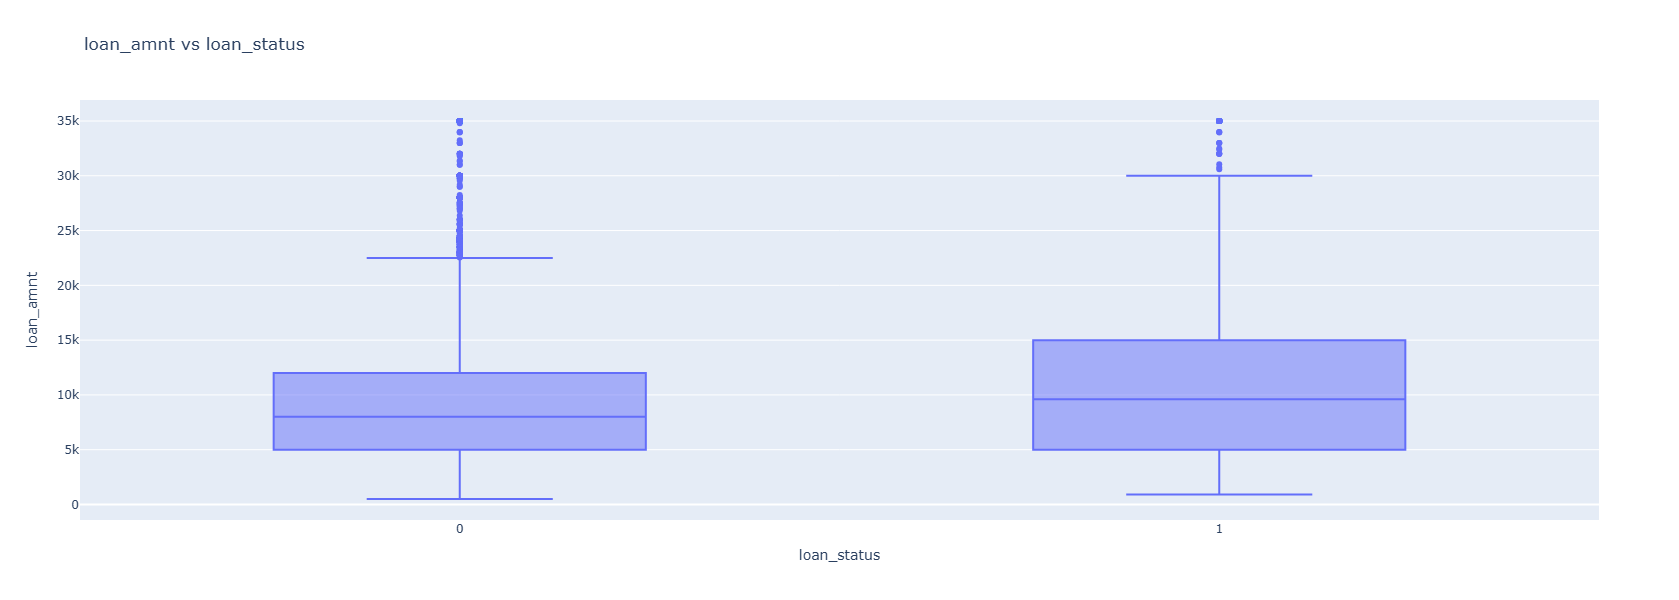

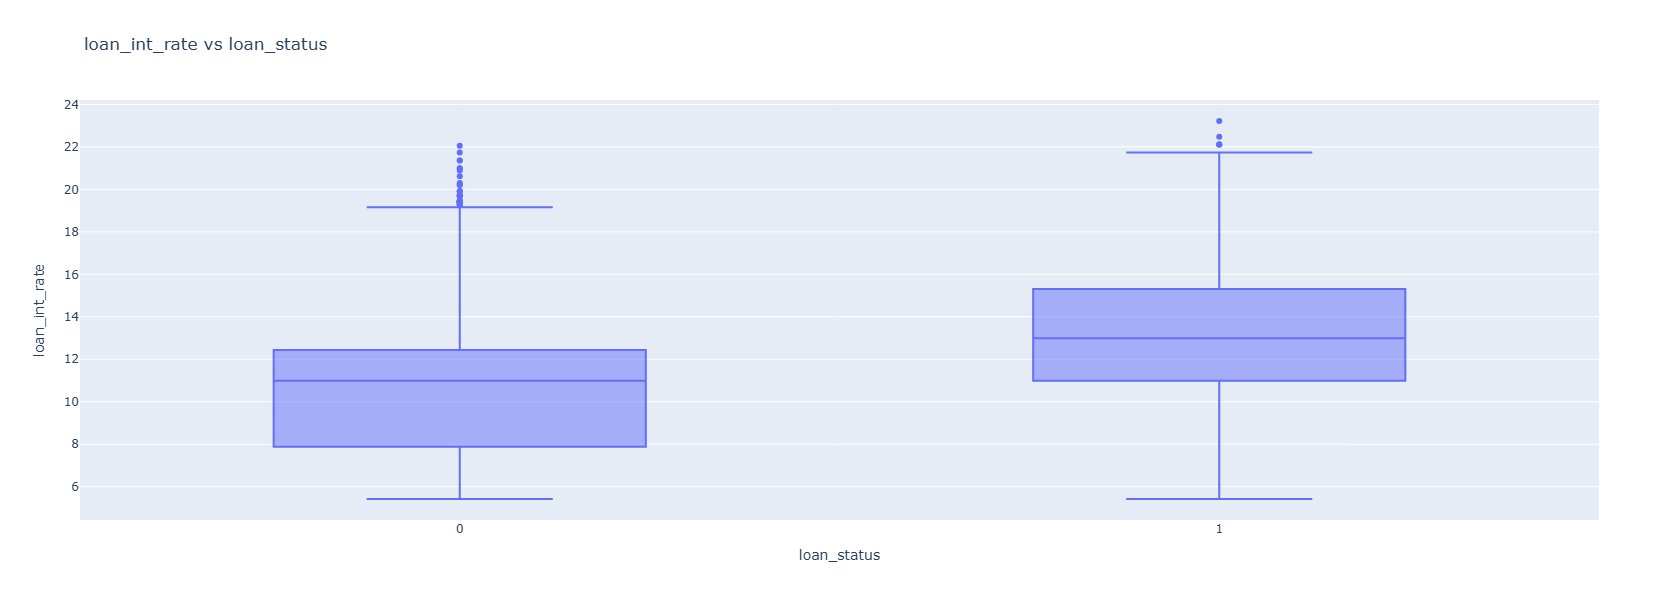

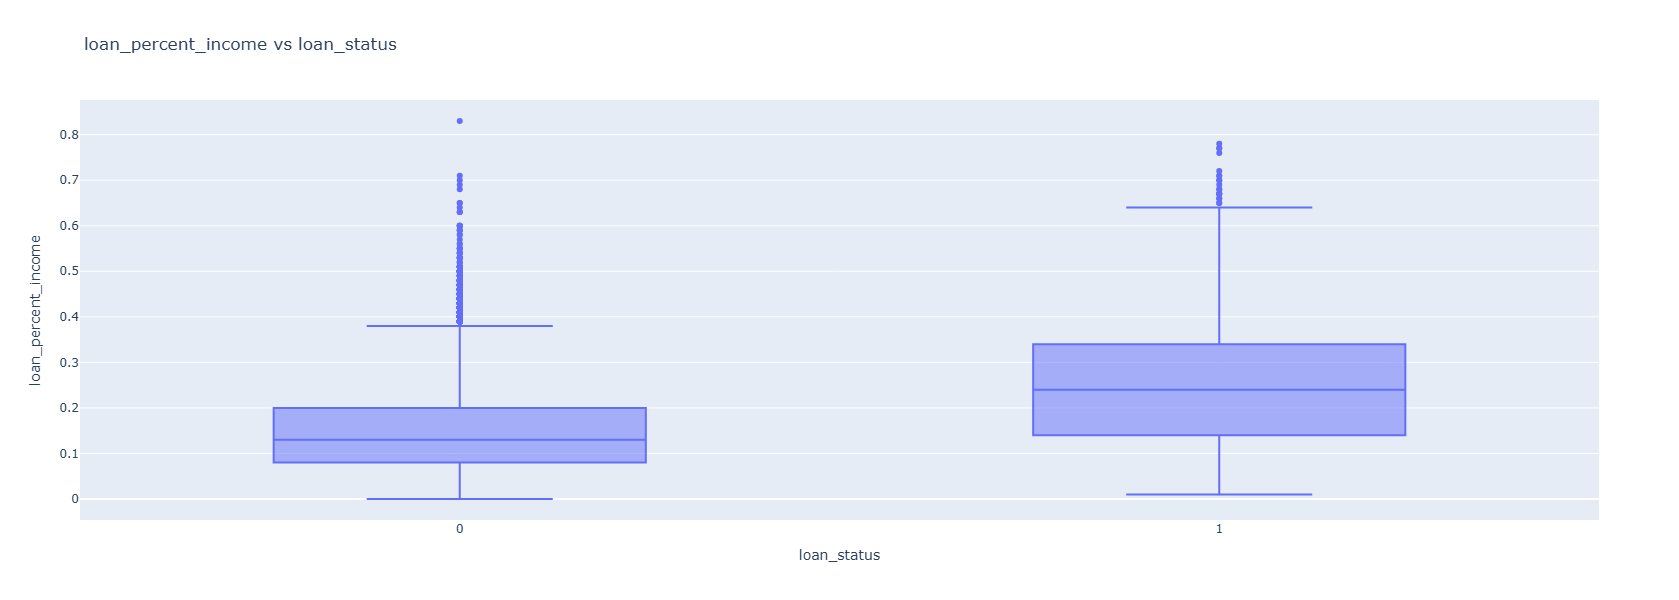

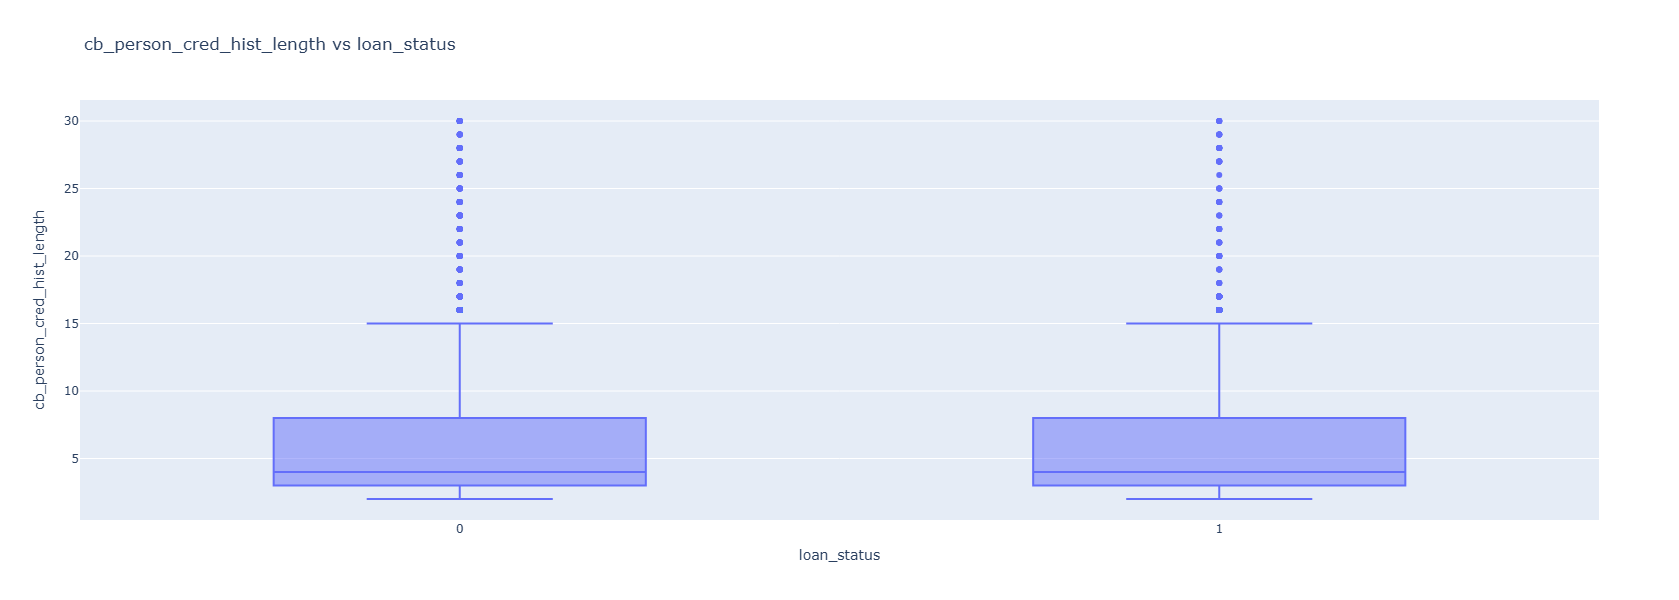

In [16]:
num_cols = df.select_dtypes(include='number').columns.drop('loan_status')

for col in num_cols:
    fig = px.box(df, x='loan_status', y=col, title=f'{col} vs loan_status')
    fig.update_layout(height=600)
    fig.show()



---

## Завдання 3: Аналіз кореляцій та Feature Engineering (3 бали)

**Що потрібно зробити:**
1. Побудуйте матрицю кореляцій для числових змінних.
2. Закодуйте категоріальні змінні.
3. Виберіть фінальний набір ознак, можна лишити всі, якщо ви вважаєте, що це - доцільно.



In [18]:
corr = df.select_dtypes(include='number').corr()
corr

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
person_age,1.000000,0.117981,0.161454,0.050787,0.011853,-0.021629,-0.042411,0.859133
person_income,0.117981,1.000000,0.198751,0.420091,-0.017050,-0.245934,-0.367245,0.093901
person_emp_length,0.161454,0.198751,1.000000,0.113851,-0.051262,-0.082182,-0.054134,0.143069
loan_amnt,0.050787,0.420091,0.113851,1.000000,0.139483,0.105376,0.572612,0.041967
loan_int_rate,0.011853,-0.017050,-0.051262,0.139483,1.000000,0.319360,0.114514,0.015762
loan_status,-0.021629,-0.245934,-0.082182,0.105376,0.319360,1.000000,0.379366,-0.015529
loan_percent_income,-0.042411,-0.367245,-0.054134,0.572612,0.114514,0.379366,1.000000,-0.031690
cb_person_cred_hist_length,0.859133,0.093901,0.143069,0.041967,0.015762,-0.015529,-0.031690,1.000000


In [22]:
corr['loan_status'].abs().sort_values()

cb_person_cred_hist_length    0.015529
person_age                    0.021629
person_emp_length             0.082182
loan_amnt                     0.105376
person_income                 0.245934
loan_int_rate                 0.319360
loan_percent_income           0.379366
loan_status                   1.000000
Name: loan_status, dtype: float64

In [27]:
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

df_encoded.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
0,22,59000,123.0,35000,16.02,1,0.59,3,False,False,...,False,True,False,False,False,True,False,False,False,True
1,21,9600,5.0,1000,11.14,0,0.10,2,False,True,...,False,False,False,True,False,False,False,False,False,False
2,25,9600,1.0,5500,12.87,1,0.57,3,False,False,...,True,False,False,False,True,False,False,False,False,False
3,23,65500,4.0,35000,15.23,1,0.53,2,False,False,...,True,False,False,False,True,False,False,False,False,False
4,24,54400,8.0,35000,14.27,1,0.55,4,False,False,...,True,False,False,False,True,False,False,False,False,True



---

## Завдання 4: Підготовка даних та навчання моделі (3 бали)

**Що потрібно зробити:**
1. Розділіть дані на X та y
2. Поділіть на навчальну та тестову вибірки
3. Застосуйте масштабування
4. Навчіть модель логістичної регресії
5. Зробіть прогнози на тренувальній та тестовій вибірках.



In [28]:
X = df_encoded.drop('loan_status', axis=1)
y = df_encoded['loan_status']

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [53]:
y_train_pred = model.predict(X_train_scaled)

y_test_pred = model.predict(X_test_scaled)
y_test_pred_proba = model.predict_proba(X_test_scaled)


---

## Завдання 5: Оцінка якості моделі (4 бали)

**Що потрібно зробити:**
1. Побудуйте confusion matrix.
2. Обчисліть основні метрики (accuracy, precision, recall, f1).
3. Побудуйте ROC-криву та обчисліть AUC
4. Проаналізуйте важливість ознак.
5. Зробіть висновки про якість моделі та які ознаки найбільше впливають на прогноз.


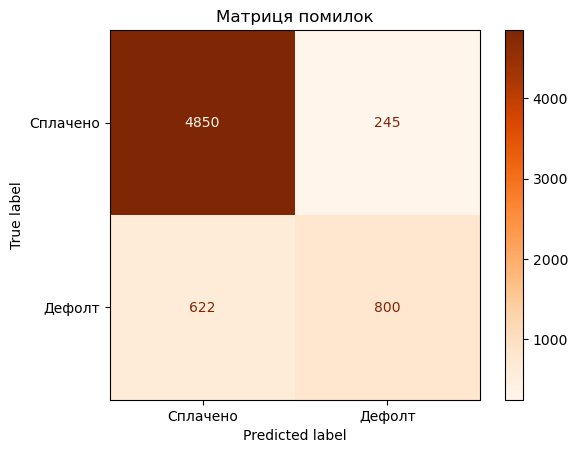

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Сплачено', 'Дефолт'])
disp.plot(cmap='Oranges')
plt.title('Матриця помилок')
plt.show()

In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print("МЕТРИКИ ЯКОСТІ МОДЕЛІ:")
print(f"Accuracy (Точність):    {accuracy:.3f}")
print(f"Precision (Влучність):  {precision:.3f}")
print(f"Recall (Повнота):       {recall:.3f}")
print(f"F1-score:               {f1:.3f}")

МЕТРИКИ ЯКОСТІ МОДЕЛІ:
Accuracy (Точність):    0.867
Precision (Влучність):  0.766
Recall (Повнота):       0.563
F1-score:               0.649


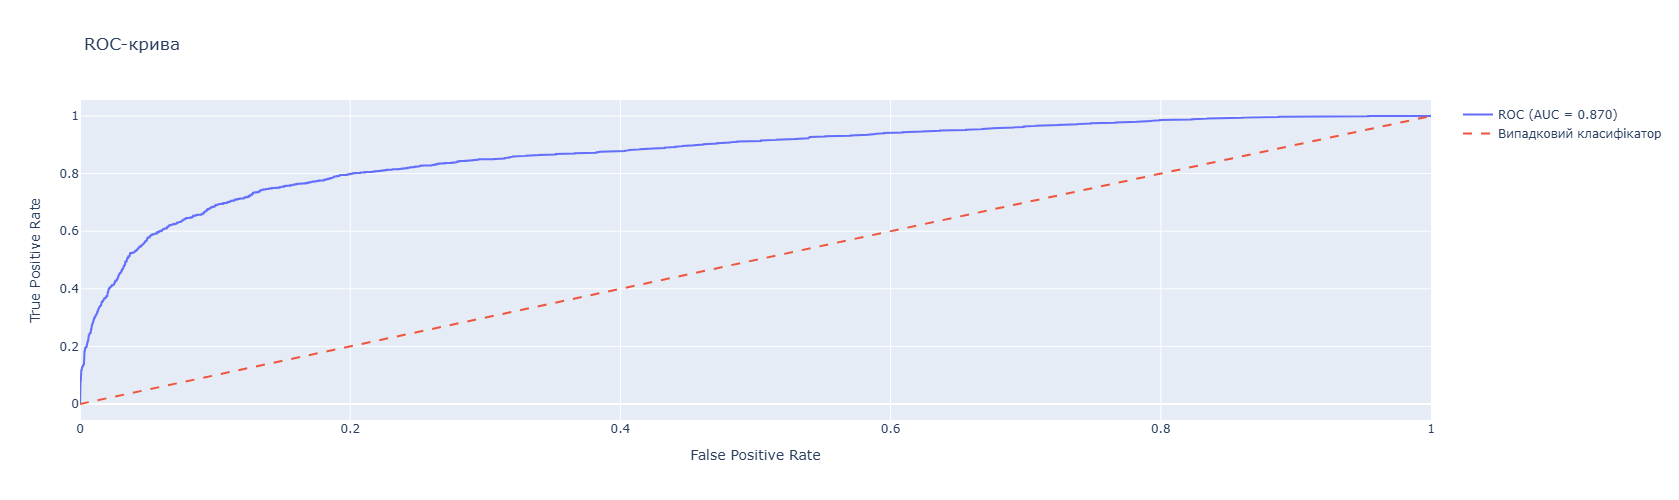

In [54]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba[:, 1])
auc = roc_auc_score(y_test, y_test_pred_proba[:, 1])

fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC (AUC = {auc:.3f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'),
                        name='Випадковий класифікатор'))
fig.update_layout(
    title='ROC-крива',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    height=500
)
fig.show()

In [55]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_[0],
    'abs_coefficient': np.abs(model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

feature_importance

,feature,coefficient,abs_coefficient
5,loan_percent_income,1.254270,1.254270
17,loan_grade_D,0.822317,0.822317
18,loan_grade_E,0.481755,0.481755
3,loan_amnt,-0.467390,0.467390
8,person_home_ownership_OWN,-0.445162,0.445162
9,person_home_ownership_RENT,0.420598,0.420598
14,loan_intent_VENTURE,-0.411387,0.411387
10,loan_intent_EDUCATION,-0.319694,0.319694
19,loan_grade_F,0.282783,0.282783
20,loan_grade_G,0.273675,0.273675


AUC дорівнює 0,870, що є високим показником і свідчить про те, що модель є хорошою.

На прогноз найбільше впливає показник співвідношення вартості кредиту до доходу.


---

## Завдання 6: Оптимізація порогу та бізнес-аналіз (2 бали)

**Що потрібно зробити:**
1. Проаналізуйте метрики precision, recall, F1 при різних порогах класифікації (мінімум - 5 різних порогів). Візуалізуйте як змінюються метрики якості при зміні порогу.
2. Оберіть оптимальний поріг для бізнес-задачі - можна обрати виходячи з попереднього пункту, або додати своїх роздумів і обрати інший.



In [64]:
thresholds = [0.2, 0.35, 0.5, 0.7, 0.85]

metrics_by_threshold = []

for t in thresholds:
    y_pred_custom = (y_test_pred_proba[:, 1] >= t).astype(int)

    metrics_by_threshold.append({
        'threshold': t,
        'precision': precision_score(y_test, y_pred_custom),
        'recall': recall_score(y_test, y_pred_custom),
        'f1': f1_score(y_test, y_pred_custom)
    })
metrics_df = pd.DataFrame(metrics_by_threshold)
metrics_df

,threshold,precision,recall,f1
0,0.20,0.524643,0.800985,0.634011
1,0.35,0.663237,0.680028,0.671528
2,0.50,0.765550,0.562588,0.648561
3,0.70,0.855932,0.355134,0.501988
4,0.85,0.931741,0.191983,0.318367


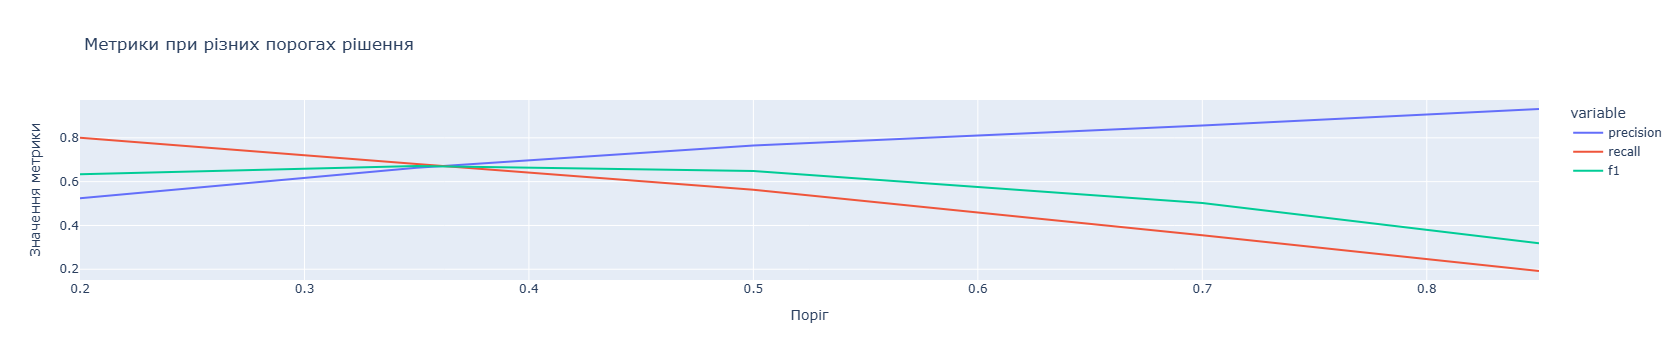

In [65]:
fig = px.line(
    metrics_df.melt(id_vars='threshold'),
    x='threshold',
    y='value',
    color='variable',
    title='Метрики при різних порогах рішення',
    labels={'value': 'Значення метрики', 'threshold': 'Поріг'},
)
fig.show()

Для нашої моделі оптимальний погір буде на рівні 0,35

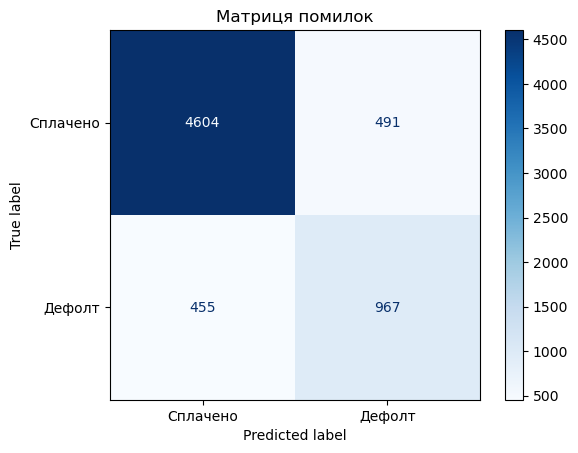

In [66]:
y_pred_opt = y_test_pred_proba[:,1]>=0.35
cm = confusion_matrix(y_test, y_pred_opt)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Сплачено', 'Дефолт'])
disp.plot(cmap='Blues')
plt.title('Матриця помилок')
plt.show()


---

## Завдання 7 (Опціональне): Покращення моделі та висновки (2 бали)

**Що потрібно зробити:**

На цих же даних навчіть DecisionTreeClassifier та RandomForestClassifier. Яка з трьох моделей дає найкращий результат на тестовому наборі?

Поріг класифікації можна для порівняння якостей моделей використовувати стандартний 0.5, або той, що ви виявили, як оптимальний на попередньому кроці.


In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [68]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_pred_proba)
    })

results_df = pd.DataFrame(results).round(3)
print(results_df)

                 Model  Accuracy  Precision  Recall     F1    AUC
0  Logistic Regression     0.867      0.766   0.563  0.649  0.870
1        Decision Tree     0.903      0.982   0.568  0.719  0.874
2        Random Forest     0.932      0.959   0.717  0.821  0.930


На тестовому наборі даних найкращій результат показала модель RandomForestClassifier.